In [1]:
using ITensors, ITensorMPS, Plots, LaTeXStrings
using ProgressMeter,Graphs, LinearAlgebra

push!(LOAD_PATH, ".")
using BP


In [2]:
function controllable_tensor(i1_in,i2_in,i1_out,i2_out;η=0)
    ## all vectors same for now in a tensor 
    ## η = mixing factor of non-rank-1 garbage
    vec = rand(dim(i1_in))
    fp = ITensor(vec,i1_in) * ITensor(vec,i2_in) * ITensor(vec,i1_out) * ITensor(vec,i2_out)
    fp = fp / norm(fp)
    fm = randomITensor(i1_in,i2_in,i1_out,i2_out)
    fm = fm / norm(fm)
    f = fp + η * fm 
    f = f / norm(f)
    return f
end 

controllable_tensor (generic function with 1 method)

In [3]:
function peps_controllable(N, T; η=0, ti=true)
    χ = 2
    vinds = [Index(χ, "v$(n)t$(t)") for n in 1:N, t in 1:T-1]
    hinds = [Index(χ, "n$(n)h$(t)") for n in 1:N-1, t in 1:T]

    down, up, left, right = Index(2,"down"), Index(2,"up"), Index(2,"left"), Index(2,"right")
    tens_main = controllable_tensor(down, up, left, right; η=η)

    tensors = []

    for n = 1:N
        for t = 1:T
            if ti 
                tens = copy(tens_main)
            else 
                down, up, left, right = Index(2,"down"), Index(2,"up"), Index(2,"left"), Index(2,"right")
                tens = controllable_tensor(down, up, left, right; η=η)
            end 
            # Vertical connections (up/down)
            if t == 1
                tens *= ITensor([.5, .5], down)
                tens *= delta(up, vinds[n, t])
            elseif t == T
                tens *= ITensor([.5, .5], up)
                tens *= delta(down, vinds[n, t - 1])
            else
                tens *= delta(down, vinds[n, t - 1])
                tens *= delta(up, vinds[n, t])
            end

            # Horizontal connections (left/right)
            if n == 1
                tens *= ITensor([.5, .5], left)
                tens *= delta(right, hinds[n, t])
            elseif n == N
                tens *= ITensor([.5, .5], right)
                tens *= delta(left, hinds[n - 1, t])
            else
                tens *= delta(left, hinds[n - 1, t])
                tens *= delta(right, hinds[n, t])
            end

            push!(tensors, tens)
        end
    end

    return tensors
end


peps_controllable (generic function with 1 method)

Only rank-1 objects, no annealing, no noise injection. Converges.

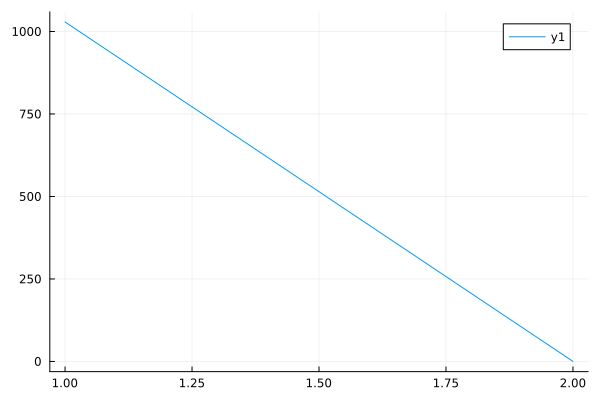

In [19]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=0.00,ti=false)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=1.,η=0.0,max_iters=1000,diagnose=true)
plot(arr)

No annealing, no noise injection, with $\eta = 0.04$ controllable non-rank-one perturbation. Does not converge.

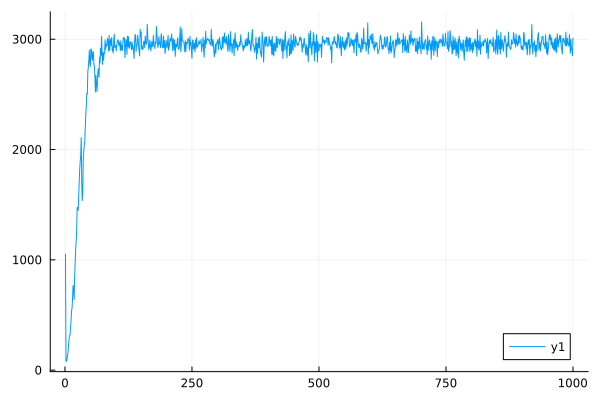

In [15]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=0.04,ti=false)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=1.,η=0.0,max_iters=1000,diagnose=true)
plot(arr)

Can make it converge if we make the message passing really slow.

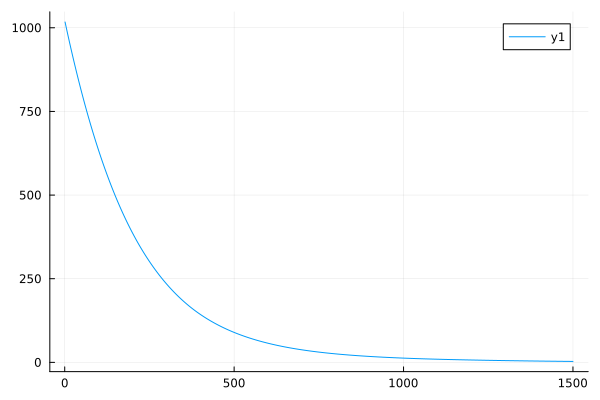

In [24]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=0.04,ti=false)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=.005,η=0.0,max_iters=1500,diagnose=true)
plot(arr)

Add some noise in the updates.

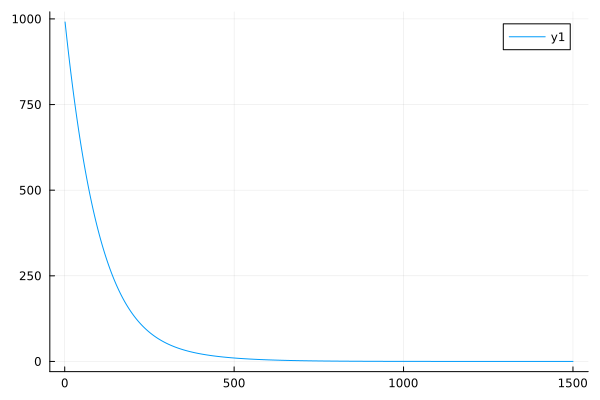

In [30]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=0.04,ti=false)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=.01,η=0.001,max_iters=1500,diagnose=true)
plot(arr)

Turn on translational invariance. Works for much higher $\eta$ values.

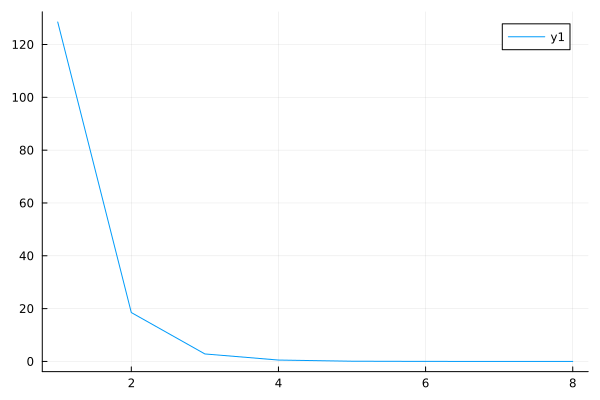

In [10]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=0.5,ti=true)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=.9,η=0.0,max_iters=1500,diagnose=true)
plot(arr)

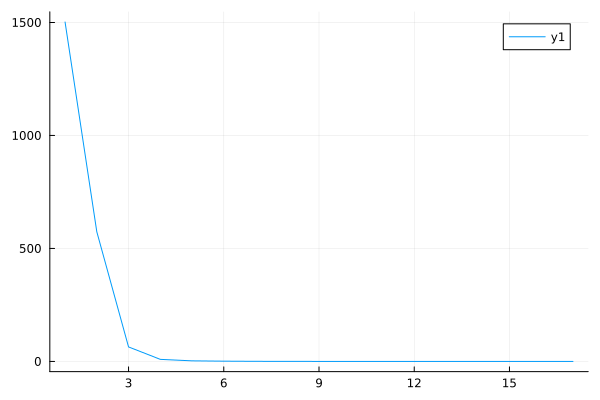

In [11]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=0.75,ti=true)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=.9,η=0.0,max_iters=1500,diagnose=true)
plot(arr)

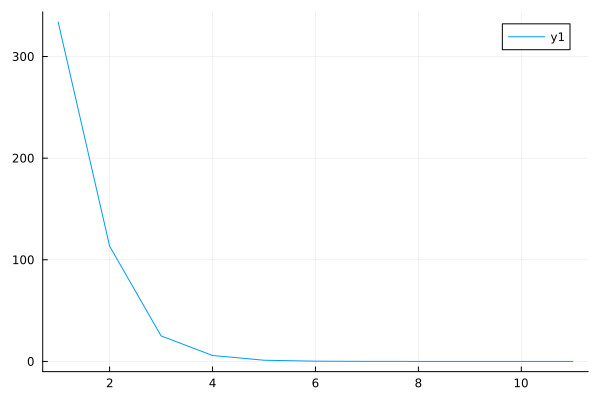

In [12]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=0.95,ti=true)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=.9,η=0.0,max_iters=1500,diagnose=true)
plot(arr)

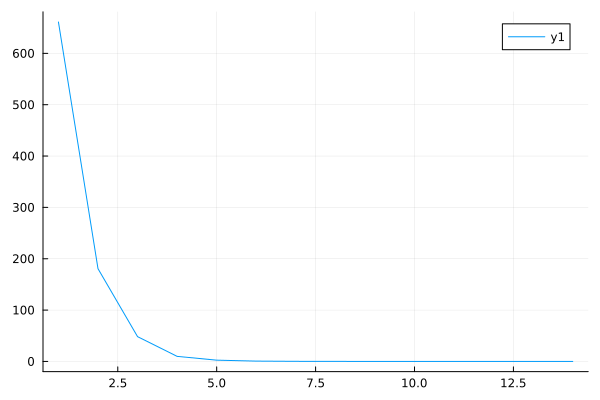

In [13]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=1.,ti=true)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=.9,η=0.0,max_iters=1500,diagnose=true)
plot(arr)